# Convolutional Neural Network Data Analysis
In this chapter, we have introduced the concepts of Convolutional Neural Networks (CNN), which are a powerful class of deep learning models particularly suited for image data. And in this project, we apply CNN techniques to a novel task in the domain of urban economics: **analyzing the housing price index of 70 large and medium-sized cities in China**. 

Rather than using traditional econometric approaches, we adopt a **time series imaging** framework. Specifically, we convert each city’s monthly housing price index time series into an image representation using methods such as Gramian Angular Fields (GAF), Markov Transition Fields (MTF), and Recurrence Plots (RP).

These image representations are then used as inputs to a ResNet-18 convolutional neural network. The goal of our model is to predict whether housing prices will increase in the future, framing this as a binary classification problem. This approach demonstrates how modern deep learning techniques can be adapted to structured economic time series data through the lens of image-based learning

**Learning Goal**: after finishing this project, you would know:
* structure of ResNet18
* build ResNet18 in PyTorch

## Contents
* [0 - Import Packages](#0---import-packages)
* [1 - Data](#1---data)
  * [1.1 - descriptive analysis](#11---descriptive-analysis)
  * [1.2 - imagine time series](#12---imagine-time-series-在后面添加几个chunk画图)
  * [1.3 - transform to DataLoader](#13---transform-to-dataloader)
* [2 - ResNet](#2---resnet)
  * [2.1 - structure](#21---structure)
  * [2.2 - basic block](#22---basic-block)
  * [2.3 - build ResNet18](#23---build-resnet18)
* [3 - Train and Test Utility](#3---train-and-test-utility)
* [4 - Results](#4---results)

## 0 - Import Packages

Most packages we have used in previous chapters. In addition, we use 3 algorithms in `pyts` to transform time series into images.

In [39]:
import pandas as pd 
import numpy as np
# used for time series imaging 
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_curve, auc, accuracy_score

np.random.seed(42)
torch.manual_seed(42)

## 1 - Data

Our data includes
* $X$: housing price indices for 70 large and medium-sized cities in China from January 2011 to October 2024 ($N = 70, T = 166$)
* $y$: if housing price increased between November 2024 and April 2025, then $y = 1$; otherwise, $y = 0$.
  

In [3]:
df = pd.read_csv('data.csv') # read data
df.head(5) # display first 5 rows

,city,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,y
0,北京,100,100.5,100.5000,100.600500,100.801701,100.902503,100.902503,100.902503,100.902503,...,201.643842,200.232335,198.830709,197.836555,197.638719,196.848164,197.045012,196.650922,196.847573,0
1,天津,100,101.0,101.5050,101.708010,101.402886,101.200080,101.503680,101.605184,101.300369,...,143.390158,141.669476,140.961129,141.384012,141.666780,142.091780,141.665505,142.090502,142.658864,1
2,石家庄,100,100.2,101.1018,101.304004,101.506612,101.709625,101.913044,101.913044,102.014957,...,165.762256,165.264969,164.438644,164.274206,163.617109,163.453492,162.963131,162.800168,162.474568,0
3,太原,100,99.6,99.8988,100.098598,100.498992,100.800489,101.002090,101.002090,101.103092,...,132.750437,133.148689,133.414986,133.548401,133.548401,133.949046,134.082995,134.351161,134.754215,1
4,呼和浩特,100,100.7,101.0021,101.810117,102.217357,102.421792,102.729057,102.831786,102.831786,...,151.713299,150.803019,149.596595,148.549418,147.361023,146.476857,145.597996,144.870006,144.580266,0


### 1.1 - descriptive analysis

Firstly, we can visualing the price trends and compare the the average housing price index trends between two classes of cities ($y = 1$ and $y = 0$).

We observe 
* from 2015 to 2018, $y=1$ cities exhibited a faster acceleration in housing prices than $y=0$ cities.
* from 2021 to 2023, $y=1$ cities experienced some fluctuation but generally maintained high price levels, while $y=0$ cities underwent a clear and sustained decline

This supports the idea that recent housing price performance is path-dependent, and it justifies using time series imaging and deep learning methods to extract rich temporal features for classification tasks.

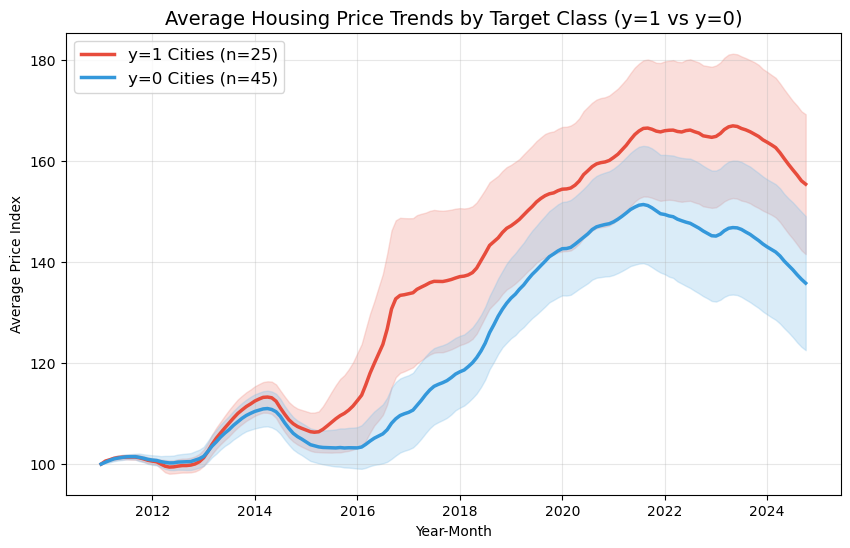

In [4]:
# extract time series columns
ts_columns = [col for col in df.columns if col >= '2011-01' and col <= '2024-10']

# transform the time series columns to datetime format
months = pd.to_datetime(ts_columns, format='%Y-%m')

# calculate mean for each class (y = 1, y = 0)
y1_mean = df[df['y'] == 1][ts_columns].mean(axis=0).values
y0_mean = df[df['y'] == 0][ts_columns].mean(axis=0).values

# calculate standard deviation for each class
y1_std = df[df['y'] == 1][ts_columns].std(axis=0).values
y0_std = df[df['y'] == 0][ts_columns].std(axis=0).values

# plot the average trend for each class
plt.figure(figsize=(10, 6))
plt.plot(months, y1_mean, label=f'y=1 Cities (n={len(df[df["y"]==1])})', color='#E74C3C', linewidth=2.5)
plt.plot(months, y0_mean, label=f'y=0 Cities (n={len(df[df["y"]==0])})', color='#3498DB', linewidth=2.5)

# plot 0.5*sd for each class
plt.fill_between(months, y1_mean - 0.5*y1_std, y1_mean + 0.5*y1_std, color='#F1948A', alpha=0.3)
plt.fill_between(months, y0_mean - 0.5*y0_std, y0_mean + 0.5*y0_std, color='#85C1E9', alpha=0.3)

# set plot aesthetics
plt.title('Average Housing Price Trends by Target Class (y=1 vs y=0)', fontsize=14)
plt.xlabel('Year-Month', fontsize=10)
plt.ylabel('Average Price Index', fontsize=10)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### 1.2 - imagine time series

Next, we need to transform our time series data into images. 

But before that we define a function `split_housing_price_data` in the following steps:
1. extract time series data $X$ in `df` to a NumPy array
2. extract label $y$ in `df` to a NumPy array
3. extract city names in `df` to a NumPy array
4. split into training and testing samples

In [5]:
def split_housing_price_data(df):
    '''
    split data to train and test array
    param:
        df: dataframe with columns ['city', 'y', '2011-01', ..., '2024-10'];
    return:
        train_ts: ndarray with shape [N, T], time series data for training;
        test_ts: ndarray with shape [N, T], time series data for testing;
        train_y: ndarray with shape [N,], label for training;
        test_y: ndarray with shape [N,], label for testing;
    '''
    # extract time series data to a NumPy array: shape = [N, T]
    ts_columns = [col for col in df.columns if '2011-01' <= col <= '2024-10']
    X = df[ts_columns].values
    
    # extract label to a NumPy array: shape = [N,]
    y = df['y'].values
    
    # extract city names to a NumPy array: shape = [N,]
    city = df['city'].values
    
    # split data into training and testing sets
    train_ts, test_ts, train_y, test_y, train_city, test_city = train_test_split(X, y, city, test_size=0.2,random_state=42, shuffle=True, stratify=y)

    return train_ts, test_ts, train_y, test_y, train_city, test_city

# split the data into training and testing sets
train_ts, test_ts, train_y, test_y, train_city, test_city = split_housing_price_data(df)
# display the shapes of the resulting arrays
train_ts.shape, test_ts.shape, train_y.shape, test_y.shape

((56, 166), (14, 166), (56,), (14,))

Then, we transform our time series into images using 3 algorithms: Gramian Angular Fields, Markov Transition Field and Recurrence Plot. Each converts a 1-dimensional time series into a gray-scale image. We then stack the three gray-scale images along the channel dimension to form a 3-channel image (similar in structure to an RGB image). This 3-channel representation is well-suited as input to a convolutional neural network

For the technical details of these 3 algorithms, you can refer to [Wang and Oates (2015)](https://www.ijcai.org/Proceedings/15/Papers/553.pdf). But here for simplicity, you can think of these algorithms as simply visulizing patterns (trends, cycles, anomalies) of time series.

To finish above task, we define a function `image_time_series` in the following steps:
1. create GAF images
2. create MTF images
3. create RP images
4. stack the images along the channel dimension

In [6]:
def image_time_series(ts):
    '''
    Convert time series data into images
    param:
        ts: ndarray with shape [N, T], time series;
    return:
        images: ndarray with shape [N, 3, T, T], 3 channels image of time series;
    '''
    # create GAF images 
    gaf = GramianAngularField()
    gaf_image = gaf.fit_transform(ts) # shape [N, T, T]

    # create MTF images
    mtf = MarkovTransitionField(strategy='uniform')
    mtf_image = mtf.fit_transform(ts) # shape [N, T, T]

    # create RP images
    rp = RecurrencePlot(threshold='point')
    rp_image = rp.fit_transform(ts) # shape [N, T, T]

    # stack the images along the channel dimension
    images = np.stack([gaf_image, mtf_image, rp_image], axis=1) #  shape [N, 3, T, T]
    
    return images

train_X = image_time_series(train_ts)
test_X = image_time_series(test_ts)
train_X.shape, test_X.shape

((56, 3, 166, 166), (14, 3, 166, 166))

In the following codes, we take Xiamen as an example to show what we have after transforming our time series into images.

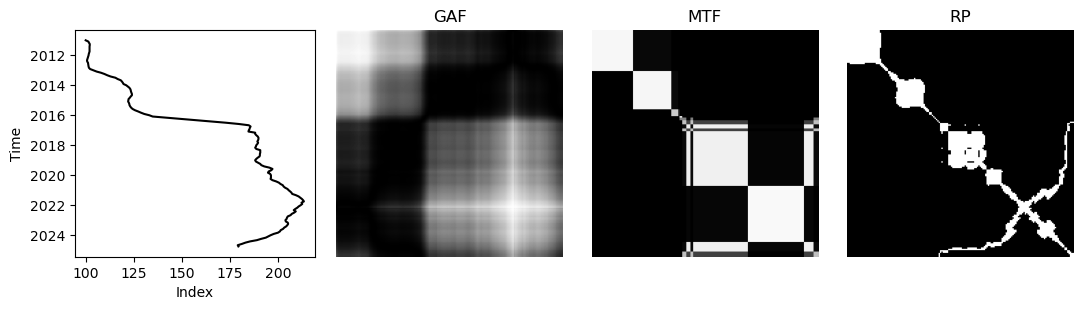

In [11]:
# find index of '厦门' 
idx = np.where(train_city == '厦门')[0][0]

# extract Xiamen's time series and images
ts = train_ts[idx]                   # shape: [T]
images = train_X[idx]               # shape: [3, T, T]

# create plot with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(11, 3))

# draw curve of time series
axes[0].plot(ts, months, color='black')
axes[0].invert_yaxis()
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Time')

# draw GAF image
axes[1].imshow(images[0], cmap='gray')
axes[1].set_title('GAF')
axes[1].axis('off')

# draw MTF image
axes[2].imshow(images[1], cmap='gray')
axes[2].set_title('MTF')
axes[2].axis('off')

# draw RP image
axes[3].imshow(images[2], cmap='gray')
axes[3].set_title('RP')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### 1.3 - transform to DataLoader

Finally, we define a function `prepare_loader`, which transform our Numpy array data into DataLoader, in the following steps:
1. transform `X` and `y` into torch.tensor
2. bundle `X` and `y` into TensorDataset
3. transform TensorDataset into DataLoader

In [ ]:
# to DataLoader
def prepare_loader(X, y, batch_size=64, shuffle=True):
    '''
    Prepare DataLoader for training and testing
    param:
        X: ndarray with shape [N, C, T, T], images;
        y: ndarray with shape [N,], labels;
        batch_size: int, size of each batch;
    return:
        loader: DataLoader object;
    '''
    # transform X into torch.tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # transform y into torch.tensor
    y_tensor = torch.tensor(y, dtype=torch.long)

    # bundle X_tensor and y_tensor into a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # transform the dataset into a DataLoader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

train_loader = prepare_loader(train_X, train_y, shuffle=True)
test_loader = prepare_loader(test_X, test_y, shuffle=False)

## 2 - ResNet

### 2.1 - structure

### 2.2 - basic block

In [13]:
class BasicBlock(nn.Module):
    # 定义扩展因子，用于调整输出通道数
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        """
        初始化 BasicBlock 模块。

        参数:
        - in_channels: 输入特征图的通道数
        - out_channels: 输出特征图的通道数
        - stride: 卷积步长，默认为 1
        """
        super(BasicBlock, self).__init__()

        # 第一个卷积层：3x3 卷积，用于提取特征
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # 第一个批归一化层：对卷积后的输出进行归一化
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 第二个卷积层：3x3 卷积，用于进一步提取特征
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # 第二个批归一化层：对卷积后的输出进行归一化
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 定义 shortcut 连接（残差连接）
        self.shortcut = nn.Sequential()  # 默认 shortcut 是恒等映射（identity mapping）

        # 如果步长不为 1 或输入通道数与输出通道数不匹配，则需要调整 shortcut
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                # 1x1 卷积，用于调整通道数和空间尺寸
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                # 批归一化层
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # 第一层卷积 + 批归一化 + ReLU 激活
        out = F.relu(self.bn1(self.conv1(x)))

        # 第二层卷积 + 批归一化
        out = self.bn2(self.conv2(out))

        # 将 shortcut 的输出与主路径的输出相加（残差连接）
        out += self.shortcut(x)

        # 对相加后的结果应用 ReLU 激活
        out = F.relu(out)

        return out

### 2.3 - build resnet18

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        """
        初始化 ResNet 模型。

        参数:
        - block: 残差块类型（如 BasicBlock）
        - num_blocks: 每个阶段的残差块数量（如 [2, 2, 2, 2] 对应 ResNet-18）
        - num_classes: 分类任务的类别数
        """
        super(ResNet, self).__init__()

        # 初始通道数
        self.in_channels = 64

        # 初始卷积层：3x3 卷积，用于提取初步特征
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 构建 4 个阶段的残差块堆叠
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)  # 第一阶段
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # 第二阶段
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # 第三阶段
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # 第四阶段

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化层
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        构建一个阶段的残差块堆叠。

        参数:
        - block: 残差块类型（如 BasicBlock）
        - out_channels: 输出通道数
        - num_blocks: 残差块数量
        - stride: 第一个残差块的步长

        返回:
        - nn.Sequential: 一个阶段的残差块堆叠
        """
        # 定义每个残差块的步长列表
        # 第一个残差块使用指定的 stride，后续残差块使用 stride=1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        # 构建每个残差块
        for stride in strides:
            # 添加一个残差块
            layers.append(block(self.in_channels, out_channels, stride))
            # 更新输入通道数
            self.in_channels = out_channels * block.expansion

        # 将残差块堆叠成一个序列
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        前向传播函数。

        参数:
        - x: 输入图像

        返回:
        - out: 分类结果
        """
        # 初始卷积层 + 批归一化 + ReLU 激活
        out = self.relu(self.bn1(self.conv1(x))) # (56, 64, 83, 83)
        out = self.maxpool(out) # (56, 64, 42, 42)

        # 通过 4 个阶段的残差块堆叠
        out = self.layer1(out)  # (56, 64, 42, 42)
        out = self.layer2(out)  # (56, 128, 21, 21)
        out = self.layer3(out)  # (56, 256, 11, 11)
        out = self.layer4(out)  # (56, 512, 6, 6)

        # 全局平均池化：将特征图的空间维度压缩为 1x1
        out = self.avgpool(out) # (56, 512, 1, 1)

        # 展平为向量
        out = torch.flatten(out, 1) # (56, 512)

        # 全连接层：将特征向量映射到类别数量
        out = self.linear(out)

        return out
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

## 3 - Train and Test Utility

In [30]:
# 训练函数
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        loss_list.append([])
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
                loss_list[-1].append(loss.item())
    return loss_list

# 测试函数
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    test_loss = 0
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            probs = torch.softmax(output, dim=1)[:, 1]  # 概率取 class 1
            
            all_probs.append(probs.cpu())
            all_targets.append(target.cpu())

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    probs = torch.cat(all_probs, dim=0).numpy()
    targets = torch.cat(all_targets, dim=0).numpy()

    return probs, targets


In [19]:
# 实例化 ResNet-18 模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [20]:
loss_list = train(model, train_loader, criterion, optimizer, 100, device=device)

Epoch 0, Batch 0, Loss: 0.7304930090904236
Epoch 1, Batch 0, Loss: 0.5071220993995667
Epoch 2, Batch 0, Loss: 0.507554829120636
Epoch 3, Batch 0, Loss: 1.3225278854370117
Epoch 4, Batch 0, Loss: 0.5463858842849731
Epoch 5, Batch 0, Loss: 0.16857896745204926
Epoch 6, Batch 0, Loss: 0.08150564134120941
Epoch 7, Batch 0, Loss: 0.02784404717385769
Epoch 8, Batch 0, Loss: 0.0073885549791157246
Epoch 9, Batch 0, Loss: 0.005206610541790724
Epoch 10, Batch 0, Loss: 0.003437293926253915
Epoch 11, Batch 0, Loss: 0.0023891266901046038
Epoch 12, Batch 0, Loss: 0.0022029445972293615
Epoch 13, Batch 0, Loss: 0.0025674307253211737
Epoch 14, Batch 0, Loss: 0.0023673786781728268
Epoch 15, Batch 0, Loss: 0.0018355145584791899
Epoch 16, Batch 0, Loss: 0.0014452941250056028
Epoch 17, Batch 0, Loss: 0.0012002039002254605
Epoch 18, Batch 0, Loss: 0.0010522936936467886
Epoch 19, Batch 0, Loss: 0.0009327352163381875
Epoch 20, Batch 0, Loss: 0.0008181249722838402
Epoch 21, Batch 0, Loss: 0.0007178114028647542


In [40]:
probs_resnet, targets = test(model, test_loader, criterion, device=device)
accuracy_score(targets, (probs_resnet > 0.5).astype(int))

Test Loss: 0.0599


0.7857142857142857

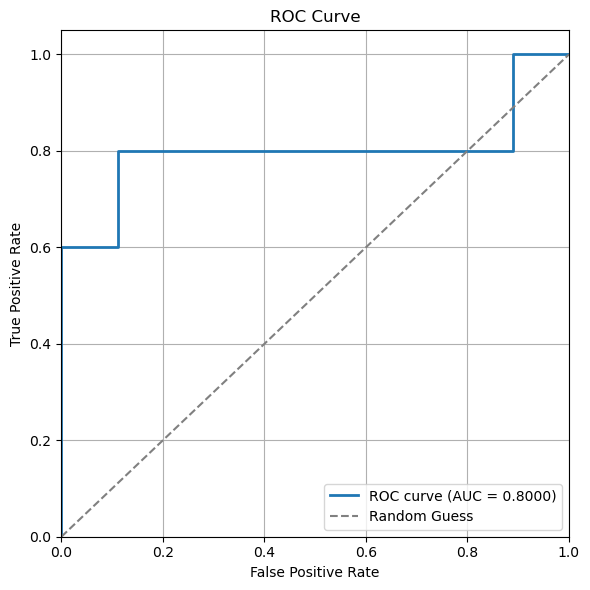

In [ ]:
fpr, tpr, thresholds = roc_curve(targets, probs_resnet)
roc_auc = auc(fpr, tpr)

# 绘制
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 4 - Results and Comparison

### 4.1 - ARIMA